# GRU Encoder with Self-Attention Hybrid

This notebook keeps the multi-head decoder from the previous step but augments the GRU encoder with a **self-attention block**.
The encoder first runs a stacked GRU and then applies multi-head self-attention plus Add&Norm to capture long-range source
relationships before handing contextual states to the decoder.


In [ ]:



import os
import math
import torch
from torch import nn
from d2l import torch as d2l
from tsv_seq2seq_data import TSVSeq2SeqData

import importlib
import hw7
importlib.reload(hw7)
from hw7 import *



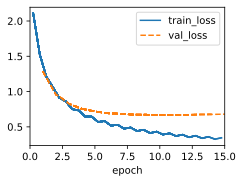

In [2]:
data_path = os.path.expanduser('~/Dropbox/CS6140/data/sentence_pairs_large.tsv')
data = TSVSeq2SeqData(
    path=data_path,
    batch_size=512,
    num_steps=25,
    min_freq=2,
    val_frac=0.05,
    test_frac=0.0,
    sample_percent=1,
)

embed_size = 256
num_hiddens = 320 
num_blks = 3 
num_layers =3
dropout = 0.35 
num_heads = 4

encoder = SelfAttentionAugmentedEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers,
                                         num_heads=num_heads, dropout=dropout)
decoder = MultiHeadSeq2SeqDecoder(len(data.tgt_vocab), embed_size,
                                  num_hiddens, num_layers, num_heads=num_heads, dropout=dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.0015)
trainer = d2l.Trainer(max_epochs=15, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


In [3]:
# examples = ['vamos .', 'me perdi .', 'esta tranquilo .', 'estoy en casa .', 'donde esta el tren ?']
# references = ['go .', 'i got lost .', 'he is calm .', 'i am at home .', 'where is the train ?']

# preds, _ = model.predict_step(
#     data.build(examples, references), d2l.try_gpu(), data.num_steps)
# for src, tgt, pred in zip(examples, references, preds):
#     translation = []
#     for token in data.tgt_vocab.to_tokens(pred):
#         if token == '<eos>':
#             break
#         translation.append(token)
#     print(f"{src} => {' '.join(translation)} | reference: {tgt}")



examples = ['vamos .', 'me perdi .', 'esta tranquilo .', 'estoy en casa .', 'donde esta el tren ?',    'necesito ayuda urgente .',
    'ayer llovio mucho en la ciudad .', 'los ninos estan jugando en el parque .', 'ella quiere aprender a hablar ingles muy bien .',
    'cuando llegara el proximo tren a madrid ?']

references = ['go .', 'i got lost .', 'he is calm .', 'i am at home .', 'where is the train ?',
    'i need urgent help .', 'it rained a lot in the city yesterday .',
    'the children are playing in the park .', 'she wants to learn to speak english very well .', 'when will the next train to madrid arrive ?']

preds, _ = model.predict_step(
    data.build(examples, references), d2l.try_gpu(), data.num_steps)
for src, tgt, pred in zip(examples, references, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(pred):
        if token == '<eos>':
            break
        translation.append(token)
    
    hypo = ' '.join(translation)
    print(f"{src} => {hypo} | reference: {tgt} BLEU: {d2l.bleu(hypo, tgt, k=2):.3f}")
    

vamos . => let's go on. | reference: go . BLEU: 0.000
me perdi . => i caught a wheat in the wind. | reference: i got lost . BLEU: 0.000
esta tranquilo . => we worked through this evening. | reference: he is calm . BLEU: 0.000
estoy en casa . => i'm home at all. | reference: i am at home . BLEU: 0.000
donde esta el tren ? => where this train goes on? | reference: where is the train ? BLEU: 0.000
necesito ayuda urgente . => i require urgent help. | reference: i need urgent help . BLEU: 0.000
ayer llovio mucho en la ciudad . => yesterday long rained in the city was in 1992. | reference: it rained a lot in the city yesterday . BLEU: 0.527
los ninos estan jugando en el parque . => the <unk> played in the park together. | reference: the children are playing in the park . BLEU: 0.498
ella quiere aprender a hablar ingles muy bien . => she wants to learn to speak very fast, very well. | reference: she wants to learn to speak english very well . BLEU: 0.722
cuando llegara el proximo tren a madri

In [4]:
for src, tgt in zip(examples, references):
    src_sentence = src.lower().split()
    src_tokens = [data.src_vocab[token] for token in src_sentence]
    pred_ids = beam_search_translate(model, src_tokens, data, beam_size=5,  max_steps=40)
    translation = data.tgt_vocab.to_tokens(pred_ids)
    hypo = ' '.join(translation)
    print(f"{src} => {hypo}    |  reference: {tgt}  | BLEU: {d2l.bleu(hypo, tgt, k=2):.3f}")

vamos . => we are going to be rainy. now. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>    |  reference: go .  | BLEU: 0.000
me perdi . => forgive me for me. i have no longer with it. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>    |  reference: i got lost .  | BLEU: 0.000
esta tranquilo . => this server is this term. and i have to be ashamed of the way. do you need to do? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>    |  reference: he is calm .  | BLEU: 0.000
estoy en casa . => i am at home by the other. i have a weak one. than i are in a 1000 animal. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 